# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [166]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [167]:
# from fsds_100719.imports import *

In [168]:
df = pd.read_csv('zillow_data.csv')

In [169]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [170]:
df.loc[df.RegionName == 95616]     # also acceptable:  df.loc[df['RegionName'] == 95616]


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
954,98312,95616,Davis,CA,Sacramento,Yolo,955,202500.0,202500.0,202500.0,...,683600,682800,679400,674400,677200,687700,696700,697500,695000,692300


# Step 2: Data Preprocessing

In [171]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [172]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## Fix problem with ZIP codes beginning with '0'

I have surmised that RegionName is the ZIP code for each entry.  RegionName values with only 4 digits represent ZIP codes that actually begin with '0'.  So that I can work with ZIP codes in the data set, I will need to add that zero onto every 4-digit RegionName value.  Once that's completed, I'll rename this column "ZipCode".  

In [173]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [174]:
# df.RegionName.sort_values().head(10)

df.sort_values(by="RegionName").head(7)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5850,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
4199,58197,1002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
11213,58200,1005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
6850,58201,1007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
14547,58202,1008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200
11702,58204,1010,Brimfield,MA,Springfield,Hampden,11703,115800.0,115700.0,115500.0,...,246400,247500,249100,248800,245400,243800,244600,246700,248800,250900
14475,58205,1011,Chester,MA,Springfield,Hampden,14476,87000.0,87000.0,87100.0,...,160200,156700,156600,157700,155400,151400,150100,150100,149500,149100


In [175]:
df['RegionName'] = df.RegionName.astype(str)
df['RegionName'].dtype


dtype('O')

In [176]:
df.rename(columns={'RegionName': 'Zip'}, inplace=True)
df.columns
df.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [177]:
zips = []

for i in df['Zip']:
    if len(i) < 5:
        i = '0' + i
        zips.append(i)
    else:
        zips.append(i)

zips
df['Zip'] = pd.Series(zips)
df.sort_values(by='Zip').head(10)


,RegionID,Zip,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5850,58196,01001,Agawam,MA,Springfield,Hampden,5851,113100.0,112800.0,112600.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
4199,58197,01002,Amherst,MA,Springfield,Hampshire,4200,161000.0,160100.0,159300.0,...,333700,334800,336700,338900,340400,342000,344500,347400,350600,353300
11213,58200,01005,Barre,MA,Worcester,Worcester,11214,103100.0,103400.0,103600.0,...,205600,206800,208800,210400,211300,213300,215600,217900,219500,220700
6850,58201,01007,Belchertown,MA,Springfield,Hampshire,6851,133400.0,132700.0,132000.0,...,266100,266300,267000,267500,268000,268100,268100,268800,270000,270600
14547,58202,01008,Blandford,MA,Springfield,Hampden,14548,117500.0,117300.0,117100.0,...,202400,202900,205900,208500,207500,205400,204500,206800,210900,214200
11702,58204,01010,Brimfield,MA,Springfield,Hampden,11703,115800.0,115700.0,115500.0,...,246400,247500,249100,248800,245400,243800,244600,246700,248800,250900
14475,58205,01011,Chester,MA,Springfield,Hampden,14476,87000.0,87000.0,87100.0,...,160200,156700,156600,157700,155400,151400,150100,150100,149500,149100
4568,58207,01013,Chicopee,MA,Springfield,Hampden,4569,88500.0,88500.0,88400.0,...,167700,169300,171100,171900,172300,173300,174600,175900,176900,177400
2694,58209,01020,Chicopee,MA,Springfield,Hampden,2695,97200.0,97100.0,97000.0,...,178600,181000,184100,186100,186800,187400,188100,189000,189600,189800
14594,58212,01026,Cummington,MA,Springfield,Hampshire,14595,91200.0,91100.0,91000.0,...,193400,195900,200800,202600,201800,201200,204600,211200,217900,220800


In [178]:
# The function below is from the original starter notebook. 
# I modified the function to return the entire melted df, not the 
# melted dataframe grouped by time and aggregated by mean value
# (the pd.IndexSlice method might work to resolve this issue...?)
# from JI notebook:  df = df2.loc[pd.IndexSlice[:, '2014-01-01':], :].copy()
# df.reset_index(inplace=True, level=0, drop=True)
# ts = df['value'].loc['2010':]
# ts = df.loc[df['Zip']==1267]
# ts = df.loc[df['Zip']==1267]["value"].rename(1267)
# ts = ts.resample('MS').asfreq()
# ts.plot()

# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

# df_melt = melt_data(df)

## Melt Function

In [179]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted   

In [180]:
df_melt = melt_data(df)


In [181]:
df_melt.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [182]:
df_melt.sort_values("Zip")

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,time,value
1860948,58196,01001,Agawam,MA,Springfield,Hampden,5851,2006-10-01,220600.0
3524647,58196,01001,Agawam,MA,Springfield,Hampden,5851,2016-03-01,195900.0
3244910,58196,01001,Agawam,MA,Springfield,Hampden,5851,2014-08-01,186400.0
638939,58196,01001,Agawam,MA,Springfield,Hampden,5851,1999-11-01,122100.0
182526,58196,01001,Agawam,MA,Springfield,Hampden,5851,1997-04-01,112500.0
...,...,...,...,...,...,...,...,...,...
1626823,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,2005-06-01,220300.0
3894165,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,2018-04-01,305100.0
1170410,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,2002-11-01,185300.0
610936,100478,99901,Ketchikan,AK,Ketchikan,Ketchikan Gateway,7294,1999-09-01,140000.0


In [183]:
df_melt.isna().sum()

RegionID           0
Zip                0
City               0
State              0
Metro         236023
CountyName         0
SizeRank           0
time               0
value              0
dtype: int64

In [184]:
df_melt['Metro'].fillna('Missing', inplace=True)
df_melt.isna().sum()

RegionID      0
Zip           0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

## Setting index as time (df_melt1)

In [185]:
df_melt1 = df_melt.set_index('time')

In [186]:
df_melt1.head()

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


## Setting time and Zip as indices (df_melt2)

In [187]:
# From James Irving's study group (one way to create a dataframe)

df_melt2 = df_melt1.groupby('Zip').resample('MS').asfreq()
df_melt2

RegionID    Zip       City State        Metro  \
Zip   time                                                        
01001 1996-04-01     58196  01001     Agawam    MA  Springfield   
      1996-05-01     58196  01001     Agawam    MA  Springfield   
      1996-06-01     58196  01001     Agawam    MA  Springfield   
      1996-07-01     58196  01001     Agawam    MA  Springfield   
      1996-08-01     58196  01001     Agawam    MA  Springfield   
...                    ...    ...        ...   ...          ...   
99901 2017-12-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-01-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-02-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-03-01    100478  99901  Ketchikan    AK    Ketchikan   
      2018-04-01    100478  99901  Ketchikan    AK    Ketchikan   

                         CountyName  SizeRank     value  
Zip   time                                               
01001 1996-04-01            Hampden      5851  113100.0  
      1996-05-01            Hampden      5851  112800.0  
      1996-06-01            Hampden      5851  112600.0  
      1996-07-01            Hampden      5851  112300.0  
      1996-08-01            Hampden      5851  112100.0  
...                             ...       ...       ...  
99901 2017-12-01  Ketchikan Gateway      7294  291900.0  
      2018-01-01  Ketchikan Gateway      7294  294200.0  
      2018-02-01  Ketchikan Gateway      7294  297500.0  
      2018-03-01  Ketchikan Gateway      7294  302100.0  
      2018-04-01  Ketchikan Gateway      7294  305100.0  

[3744704 rows x 8 columns]

## Creating Sacramento df from df_melt2

In [188]:
df_sac = df_melt2.loc[df_melt2.Metro == 'Sacramento']

In [189]:
df_sac

RegionID    Zip              City State       Metro  \
Zip   time                                                              
95602 1996-04-01     98298  95602            Auburn    CA  Sacramento   
      1996-05-01     98298  95602            Auburn    CA  Sacramento   
      1996-06-01     98298  95602            Auburn    CA  Sacramento   
      1996-07-01     98298  95602            Auburn    CA  Sacramento   
      1996-08-01     98298  95602            Auburn    CA  Sacramento   
...                    ...    ...               ...   ...         ...   
96150 2017-12-01     98663  96150  South Lake Tahoe    CA  Sacramento   
      2018-01-01     98663  96150  South Lake Tahoe    CA  Sacramento   
      2018-02-01     98663  96150  South Lake Tahoe    CA  Sacramento   
      2018-03-01     98663  96150  South Lake Tahoe    CA  Sacramento   
      2018-04-01     98663  96150  South Lake Tahoe    CA  Sacramento   

                 CountyName  SizeRank     value  
Zip   time                                       
95602 1996-04-01     Placer      6185  184300.0  
      1996-05-01     Placer      6185  184000.0  
      1996-06-01     Placer      6185  183700.0  
      1996-07-01     Placer      6185  183500.0  
      1996-08-01     Placer      6185  183300.0  
...                     ...       ...       ...  
96150 2017-12-01  El Dorado      5493  412900.0  
      2018-01-01  El Dorado      5493  417500.0  
      2018-02-01  El Dorado      5493  422700.0  
      2018-03-01  El Dorado      5493  428200.0  
      2018-04-01  El Dorado      5493  432500.0  

[23960 rows x 8 columns]

In [190]:
df_sac.CountyName.unique()

array(['Placer', 'Yolo', 'Sacramento', 'El Dorado'], dtype=object)

In [202]:
df_sac.Zip.value_counts().head(10)

95618    265
95811    265
95655    265
95608    265
95616    265
95829    265
95722    265
96146    265
96142    265
95610    265
Name: Zip, dtype: int64

## Creating California df from df_melt2

In [191]:
df_cal = df_melt2.loc[df_melt2.State == 'CA']
df_cal.head()

RegionID    Zip             City State  \
Zip   time                                                 
90001 1996-04-01     95982  90001  Florence-Graham    CA   
      1996-05-01     95982  90001  Florence-Graham    CA   
      1996-06-01     95982  90001  Florence-Graham    CA   
      1996-07-01     95982  90001  Florence-Graham    CA   
      1996-08-01     95982  90001  Florence-Graham    CA   

                                           Metro   CountyName  SizeRank  \
Zip   time                                                                
90001 1996-04-01  Los Angeles-Long Beach-Anaheim  Los Angeles      2697   
      1996-05-01  Los Angeles-Long Beach-Anaheim  Los Angeles      2697   
      1996-06-01  Los Angeles-Long Beach-Anaheim  Los Angeles      2697   
      1996-07-01  Los Angeles-Long Beach-Anaheim  Los Angeles      2697   
      1996-08-01  Los Angeles-Long Beach-Anaheim  Los Angeles      2697   

                     value  
Zip   time                  
90001 1996-04-01  117700.0  
      1996-05-01  117800.0  
      1996-06-01  117900.0  
      1996-07-01  117900.0  
      1996-08-01  118000.0

In [192]:
df_cal.Metro.unique()

array(['Los Angeles-Long Beach-Anaheim', 'Ventura', 'Riverside',
       'San Diego', 'El Centro', 'Santa Maria-Santa Barbara', 'Hanford',
       'Bakersfield', 'Fresno', 'Visalia', 'San Luis Obispo', 'Missing',
       'Madera', 'Merced', 'Salinas', 'San Francisco', 'San Jose', 'Napa',
       'Vallejo', 'Santa Rosa', 'Santa Cruz', 'Stockton', 'Modesto',
       'Clearlake', 'Ukiah', 'Eureka', 'Sacramento', 'Yuba City',
       'Truckee', 'Chico', 'Redding', 'Susanville'], dtype=object)

In [193]:
# met_list = []
# cty_list = []

# for i in df_cal.Metro:
#     for j in df_cal.CountyName:
#         met_list.append(i)
#         cty_list.append(j)
        
# print(met_list)
# print(cty_list)

In [194]:
# met_list_unique = set(met_list)
# cty_list_unique = set(cty_list)


In [195]:
# set(df_cal.Metro)

In [196]:
# set(df_cal.CountyName)

In [197]:
from collections import Counter
# Counter(df_cal.Metro)

In [198]:
# Counter(df_cal.CountyName)

In [200]:
# pd.set_option('display.max_rows', 500)

In [41]:
# pd.get_option("display.max_rows")

## Grouping Sacto df by SizeRank and City (using df_sac from df_melt2)

In [239]:
df_sac.groupby(by=['SizeRank', 'City']).mean().head(10)

,,RegionID,value
SizeRank,City,,
94,Folsom,98325,373722.264151
127,Carmichael,98304,286006.415094
147,Sacramento,98432,176912.452830
243,Roseville,98411,342930.566038
347,Elk Grove,98413,263115.471698
452,Rancho Cordova,98361,215741.886792
525,Lincoln,98341,319191.698113
695,Elk Grove,98319,289630.566038
922,Sacramento,98440,308264.905660


In [240]:
df_sac.loc[df_sac['City']=='Sacramento'].count()

RegionID      5358
Zip           5358
City          5358
State         5358
Metro         5358
CountyName    5358
SizeRank      5358
value         5358
dtype: int64

In [241]:
df_sac.loc[df_sac['City']=='Sacramento']

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,98432,95823,Sacramento,CA,Sacramento,Sacramento,147,91500.0
1996-04-01,98440,95831,Sacramento,CA,Sacramento,Sacramento,922,162600.0
1996-04-01,98431,95822,Sacramento,CA,Sacramento,Sacramento,1259,85300.0
1996-04-01,98442,95833,Sacramento,CA,Sacramento,Sacramento,2111,105300.0
1996-04-01,98451,95843,Sacramento,CA,Sacramento,Sacramento,2123,130200.0
...,...,...,...,...,...,...,...,...
2018-04-01,98449,95841,Sacramento,CA,Sacramento,Sacramento,4898,307200.0
2018-04-01,98428,95819,Sacramento,CA,Sacramento,Sacramento,5406,566100.0
2018-04-01,98426,95817,Sacramento,CA,Sacramento,Sacramento,6467,359200.0


## Creating Sacto DF with annual mean prices using df_sac from df_melt2)

In [242]:
df_sac_yr = df_sac.drop('Zip', axis=1)
df_sac_yr

,RegionID,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,
1996-04-01,98325,Folsom,CA,Sacramento,Sacramento,94,190000.0
1996-04-01,98304,Carmichael,CA,Sacramento,Sacramento,127,151100.0
1996-04-01,98432,Sacramento,CA,Sacramento,Sacramento,147,91500.0
1996-04-01,98411,Roseville,CA,Sacramento,Placer,243,192700.0
1996-04-01,98413,Elk Grove,CA,Sacramento,Sacramento,347,146800.0
...,...,...,...,...,...,...,...
2018-04-01,98355,Pilot Hill,CA,Sacramento,El Dorado,14327,546500.0
2018-04-01,98658,Tahoma,CA,Sacramento,El Dorado,14472,523600.0
2018-04-01,98657,Homewood,CA,Sacramento,Placer,14566,689700.0


In [243]:
df_sac_yr.reset_index(inplace=True, level=0, drop=True)
df_sac_yr
# df_sac_yr.groupby(pd.Grouper(freq='A')).mean()

,RegionID,City,State,Metro,CountyName,SizeRank,value
0,98325,Folsom,CA,Sacramento,Sacramento,94,190000.0
1,98304,Carmichael,CA,Sacramento,Sacramento,127,151100.0
2,98432,Sacramento,CA,Sacramento,Sacramento,147,91500.0
3,98411,Roseville,CA,Sacramento,Placer,243,192700.0
4,98413,Elk Grove,CA,Sacramento,Sacramento,347,146800.0
...,...,...,...,...,...,...,...
23955,98355,Pilot Hill,CA,Sacramento,El Dorado,14327,546500.0
23956,98658,Tahoma,CA,Sacramento,El Dorado,14472,523600.0
23957,98657,Homewood,CA,Sacramento,Placer,14566,689700.0
23958,98331,Somerset,CA,Sacramento,El Dorado,14632,241200.0


## Creating Sacto DF from original melted df before grouping by time and zip (df_melt1)

In [244]:
df_sac = df_melt1.loc[df_melt1.Metro == 'Sacramento']

In [245]:
df_sac

,RegionID,Zip,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,98325,95630,Folsom,CA,Sacramento,Sacramento,94,190000.0
1996-04-01,98304,95608,Carmichael,CA,Sacramento,Sacramento,127,151100.0
1996-04-01,98432,95823,Sacramento,CA,Sacramento,Sacramento,147,91500.0
1996-04-01,98411,95747,Roseville,CA,Sacramento,Placer,243,192700.0
1996-04-01,98413,95758,Elk Grove,CA,Sacramento,Sacramento,347,146800.0
...,...,...,...,...,...,...,...,...
2018-04-01,98355,95664,Pilot Hill,CA,Sacramento,El Dorado,14327,546500.0
2018-04-01,98658,96142,Tahoma,CA,Sacramento,El Dorado,14472,523600.0
2018-04-01,98657,96141,Homewood,CA,Sacramento,Placer,14566,689700.0


### Creating sacto annual mean price by city using df_melt1

In [256]:
df_sac_yr_city = df_sac.groupby(['CountyName', 'City']).resample('A').mean().reset_index()

In [257]:
df_sac_yr_city.head(10)

,CountyName,City,time,RegionID,SizeRank,value
0,El Dorado,Camino,1996-12-31,98393.0,10422.0,141711.111111
1,El Dorado,Camino,1997-12-31,98393.0,10422.0,145008.333333
2,El Dorado,Camino,1998-12-31,98393.0,10422.0,149683.333333
3,El Dorado,Camino,1999-12-31,98393.0,10422.0,156950.000000
4,El Dorado,Camino,2000-12-31,98393.0,10422.0,174525.000000
5,El Dorado,Camino,2001-12-31,98393.0,10422.0,203591.666667
6,El Dorado,Camino,2002-12-31,98393.0,10422.0,235066.666667
7,El Dorado,Camino,2003-12-31,98393.0,10422.0,274816.666667
8,El Dorado,Camino,2004-12-31,98393.0,10422.0,330216.666667
9,El Dorado,Camino,2005-12-31,98393.0,10422.0,400741.666667


In [258]:
# df_sac_yr = df_sac.groupby(['CountyName', 'City', 'Zip']).resample('A').mean().reset_index()
# df_sac_yr.head(100)
# df_sac_yr_cty = df_sac_yr.groupby(by=['Zip', 'time', 'CountyName']).mean()
# df_sac_yr_cty.sort_values(by=['Zip', 'CountyName'])
# df_sac_yr.groupby(by=['City', 'time', 'CountyName']).mean().head(60)


In [259]:
df_sac_yr_city = df_sac_yr_city.set_index('time')

In [260]:
df_sac_yr_city.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1288 entries, 1996-12-31 to 2018-12-31
Data columns (total 5 columns):
CountyName    1288 non-null object
City          1288 non-null object
RegionID      1288 non-null float64
SizeRank      1288 non-null float64
value         1288 non-null float64
dtypes: float64(3), object(2)
memory usage: 60.4+ KB


In [261]:
df_sac_yr_city.sort_values(by=['City', 'time']).head(20)

,CountyName,City,RegionID,SizeRank,value
time,,,,,
1996-12-31,Placer,Applegate,98392.0,13680.0,157755.555556
1997-12-31,Placer,Applegate,98392.0,13680.0,156575.000000
1998-12-31,Placer,Applegate,98392.0,13680.0,167591.666667
1999-12-31,Placer,Applegate,98392.0,13680.0,183408.333333
2000-12-31,Placer,Applegate,98392.0,13680.0,205441.666667
2001-12-31,Placer,Applegate,98392.0,13680.0,234500.000000
2002-12-31,Placer,Applegate,98392.0,13680.0,266950.000000
2003-12-31,Placer,Applegate,98392.0,13680.0,308700.000000
2004-12-31,Placer,Applegate,98392.0,13680.0,369058.333333


In [262]:
df_sac_yr_city.nunique()

CountyName       4
City            56
RegionID        58
SizeRank        59
value         1283
dtype: int64

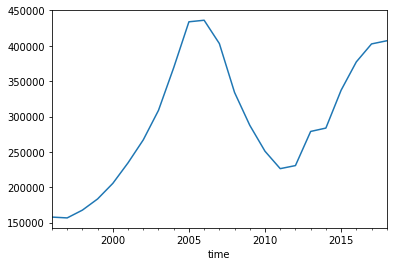

In [263]:
ts = df_sac_yr_city['value'].loc[df_sac_yr_city['City'] == 'Applegate']
ts
ts.plot()

In [264]:
sac_metro_cities = list(set(df_sac_yr_city.City))
sac_metro_cities[:10]

['Wilton',
 'Rocklin',
 'Rio Linda',
 'Elk Grove',
 'Lincoln',
 'Sacramento',
 'Georgetown',
 'Orangevale',
 'Mather Air Force Base',
 'Penryn']

In [265]:
sac_metro_cities.sort()
sac_metro_cities[:10]


['Applegate',
 'Arden-Arcade',
 'Auburn',
 'Camino',
 'Carmichael',
 'Carnelian Bay',
 'Citrus Heights',
 'Colfax',
 'Cool',
 'Davis']

In [266]:
df_sac_yr_city['value'].loc[df_sac_yr_city['City'] == 'Applegate']

time
1996-12-31    157755.555556
1997-12-31    156575.000000
1998-12-31    167591.666667
1999-12-31    183408.333333
2000-12-31    205441.666667
2001-12-31    234500.000000
2002-12-31    266950.000000
2003-12-31    308700.000000
2004-12-31    369058.333333
2005-12-31    433991.666667
2006-12-31    436191.666667
2007-12-31    403241.666667
2008-12-31    334016.666667
2009-12-31    287566.666667
2010-12-31    250891.666667
2011-12-31    226266.666667
2012-12-31    230600.000000
2013-12-31    278900.000000
2014-12-31    283658.333333
2015-12-31    337175.000000
2016-12-31    377283.333333
2017-12-31    402700.000000
2018-12-31    407150.000000
Name: value, dtype: float64

In [267]:
for i in sac_metro_cities:
    print(i)
    print(df_sac_yr_city['value'].loc[df_sac_yr_city['City'] == i])

Applegate
time
1996-12-31    157755.555556
1997-12-31    156575.000000
1998-12-31    167591.666667
1999-12-31    183408.333333
2000-12-31    205441.666667
2001-12-31    234500.000000
2002-12-31    266950.000000
2003-12-31    308700.000000
2004-12-31    369058.333333
2005-12-31    433991.666667
2006-12-31    436191.666667
2007-12-31    403241.666667
2008-12-31    334016.666667
2009-12-31    287566.666667
2010-12-31    250891.666667
2011-12-31    226266.666667
2012-12-31    230600.000000
2013-12-31    278900.000000
2014-12-31    283658.333333
2015-12-31    337175.000000
2016-12-31    377283.333333
2017-12-31    402700.000000
2018-12-31    407150.000000
Name: value, dtype: float64
Arden-Arcade
time
1996-12-31    132588.888889
1997-12-31    136052.777778
1998-12-31    138497.222222
1999-12-31    149288.888889
2000-12-31    169436.111111
2001-12-31    199497.222222
2002-12-31    230422.222222
2003-12-31    274547.222222
2004-12-31    338988.888889
2005-12-31    401177.777778
2006-12-31    3

In [268]:
for i in sac_metro_cities:
    print(i)
    print(df_sac_yr_city['value'].loc[df_sac_yr_city['City'] == i])

Applegate
time
1996-12-31    157755.555556
1997-12-31    156575.000000
1998-12-31    167591.666667
1999-12-31    183408.333333
2000-12-31    205441.666667
2001-12-31    234500.000000
2002-12-31    266950.000000
2003-12-31    308700.000000
2004-12-31    369058.333333
2005-12-31    433991.666667
2006-12-31    436191.666667
2007-12-31    403241.666667
2008-12-31    334016.666667
2009-12-31    287566.666667
2010-12-31    250891.666667
2011-12-31    226266.666667
2012-12-31    230600.000000
2013-12-31    278900.000000
2014-12-31    283658.333333
2015-12-31    337175.000000
2016-12-31    377283.333333
2017-12-31    402700.000000
2018-12-31    407150.000000
Name: value, dtype: float64
Arden-Arcade
time
1996-12-31    132588.888889
1997-12-31    136052.777778
1998-12-31    138497.222222
1999-12-31    149288.888889
2000-12-31    169436.111111
2001-12-31    199497.222222
2002-12-31    230422.222222
2003-12-31    274547.222222
2004-12-31    338988.888889
2005-12-31    401177.777778
2006-12-31    3

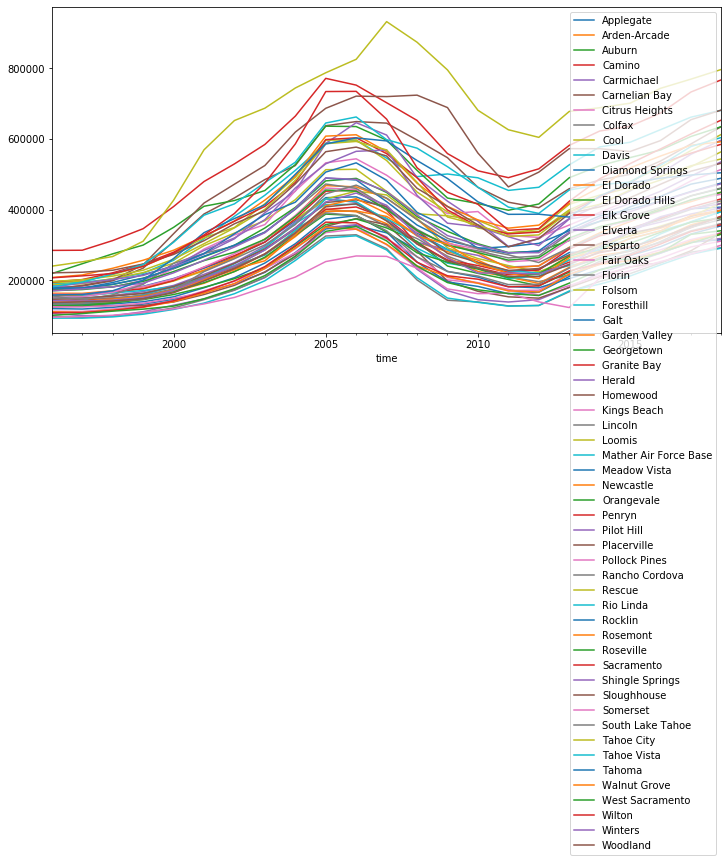

In [269]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in sac_metro_cities:
    ax = df_sac_yr_city['value'].loc[df_sac_yr_city['City'] == i].plot(label = i)
#     print(df_sac_yr['value'].loc[df_sac_yr['City'] == i])
ax.legend()



# for i in sac_metro_cities:
#     print(i)
 
#     val = [[ts_price['value']: ts_price['value'].loc[ts_price['City']==i]]]
#     ax.plot([ts_price['value'] for ts_price['value'].loc[ts_price['City']==i])

# ts_price['value'].loc[ts_price['City'] == 'Applegate']

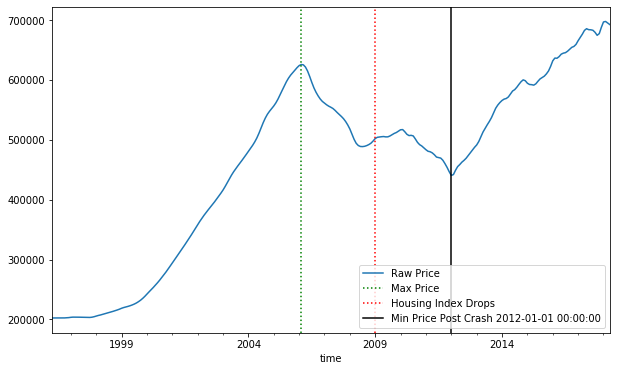

In [270]:
ts = df_melt2['value'].loc['95616']
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()


ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()

In [271]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in sac_metro_cities:
    for j in 
    ax = df_sac_yr['value'].loc[df_sac_yr['City'] == i].plot(label = i)
#     print(df_sac_yr['value'].loc[df_sac_yr['City'] == i])
ax.legend()

SyntaxError: invalid syntax (<ipython-input-271-dce1d5030bd0>, line 4)

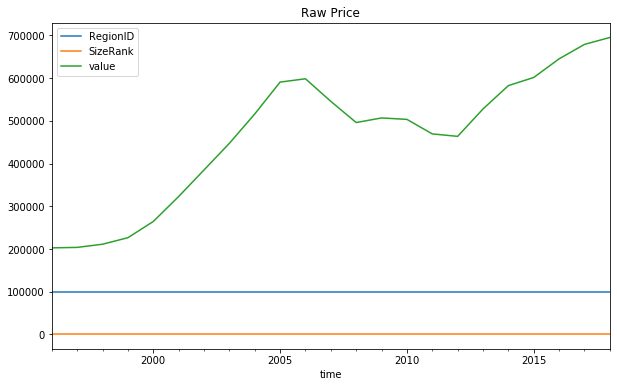

In [72]:
# Framework from James Irving's study group

ts = df_sac_yr.loc[df_sac_yr['Zip']=='95616']
ax = ts.plot(figsize=(10, 6), title = 'Raw Price')

# max_ = ts.loc['2004':'2010'].idxmax()  # 625600
# crash = '01-2009'
# min_ = ts.loc[crash:].idxmin()

# ax.axvline(max_, label='Max Price', color = 'green', ls=':')
# ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
# ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')


ax.legend()

# Step 3: EDA and Visualization

In [ ]:
# Framework from James Irving's study group

ts = df_melt2['value'].loc['95616']
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()

In [ ]:
ts = df_melt2['value'].loc['92008']
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()


In [ ]:
ts = df_melt2['value'].loc['90035']
ax = ts.plot(figsize=(10, 6), label = 'Raw Price')

max_ = ts.loc['2004':'2010'].idxmax()  # 625600
crash = '01-2009'
min_ = ts.loc[crash:].idxmin()

ax.axvline(max_, label='Max Price', color = 'green', ls=':')
ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
ax.legend()


In [ ]:
# Framework from James Irving's study group

def plot_ts(df_melt2, col='value', zipcodes=['95616']):
    
    fig, ax = plt.subplots()
    
    for zc in zipcodes:
        ts = df_melt2[col].loc[zc]
        ts.plot(figsize=(12, 8), label = str(zc), ax=ax)

#     max_ = ts.loc['2004':'2010'].idxmax()  # 625600
    crash = '01-2009'
#     min_ = ts.loc[crash:].idxmin()

#     ax.axvline(max_, label='Max Price', color = 'green', ls=':')
    ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
#     ax.axvline(min_, label=f'Min Price Post Crash {min_}', color = 'black')
    ax.legend()
    
    return fig, ax

fig, ax = plot_ts(df_melt2, zipcodes=['95616', '92008', '90035', '90025', '60625', '57701'])


In [ ]:
df_melt2.loc[95616]

In [ ]:
df_melt2.index

In [ ]:
df_sub = df_melt2.loc[pd.IndexSlice[:, '2014-01-01':], :].copy()
    

In [ ]:
df_sub.head()

In [ ]:
df_sub.index

In [ ]:
df_sub.head()

#### Pick a subset of data and move forward with that.

For now, I'll got with my current zip code.  It will be easy to change later if needed.


In [ ]:
df_sub.reset_index(inplace=True, level=0, drop=True)

In [ ]:
ts = df_sub.loc[df_sub['Zip']==95616]
ts = ts['value'].rename('95616')
ts

In [ ]:
ts = ts.resample('MS').asfreq()

In [ ]:
ts.head()

In [ ]:
ts.plot(figsize=(10, 6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

In [ ]:
def plot_acf_pacf(ts, figsize=(10,6), lags=15):
    fig, ax = plt.subplots(nrows=2, figsize=figsize)
    plot_acf(ts, ax=ax[0], lags=lags)
    plot_pacf(ts, ax=ax[1], lags=lags)
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    
plot_acf_pacf(ts)

In [ ]:
decomp = seasonal_decompose(ts)
ts_seasonal = decomp.seasonal

ax = ts_seasonal.plot()
fig = ax.get_figure()
fig.set_size_inches(10,4)

min_ = ts_seasonal.idxmin()
max_ = ts_seasonal.idxmax()
max_2 = ts_seasonal.loc[min_:].idxmax()
min_2 = ts_seasonal.loc[max_2:].idxmin()


ax.axvline(min_, label=min_, c='orange')
ax.axvline(max_, c='orange', ls=':')
ax.axvline(min_2, c='orange')
ax.axvline(max_2, c='orange', ls=':')

period = min_2 - min_ 
ax.set_title(f'Season Length = {period}')

# Step 4:  ARIMA Modeling

In [ ]:
mpl.rcParams['figure.figsize']=(12, 5)
ts.plot()
plt.figure()

for i in range(3):
    ax = ts.diff(i).plot(label = i)
#     ax.set

plt.legend()

In [ ]:
import itertools

p_range = range(0, 10)
q_range = range(0, 10)
d_range = range(1, 3)
m_range = (0, 6, 12)

pdq = list(itertools.product(p_range, d_range, q_range))
PDQM = list(itertools.product(p_range, d_range, q_range, m_range))
PDQM[:10]

In [ ]:
def make_pdq_pdqm(p_range=(0,4), d_range=(0,3), q_range=(0,4), make_seasonal=True,
                  m_values=(0,12)):
    import itertools
    ps =range(p_range[0],p_range[1])
    ds =range(d_range[0],d_range[1])
    qs =range(q_range[0],q_range[1])
    
    params = {}
    params['pdq'] = list(itertools.product(ps,ds,qs))
    
    if make_seasonal:
        params['PDQm'] = list(itertools.product(ps,ds,qs,m_values))
    return params

params = make_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQm'][:10]
    

In [ ]:
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split

def train_test_split_ts(ts, TEST_SIZE = 0.2, min_test_ts = 2):
    idx_split = get_train_test_split_index(ts, TEST_SIZE = TEST_SIZE, min_test_ts = min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test


In [ ]:
ts_train, ts_test = train_test_split_ts(ts)
len(ts_train), len(ts_test)

In [ ]:
def get_now(return_dt = True, return_str=True, show=False):
    import datetime as dt
    import tzlocal as tz
    now=dt.datetime.now(tz=tz.get_localzone())
    str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
    
    output=[]
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
    return output[:]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search_sarimax(ts_train,pdq=None,pdqm=None,order_dict=None,
                        verbose=False, model_kws={}):

    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq= order_dict['pdq']
    if (pdqm is None) & (order_dict is not None):
        pdqm= order_dict['PDQm']

#     import tqdm
#     from tqdm import trange

    start,start_str = get_now(return_dt=True, return_str=True)
    print(f'[i] STARTING GRID SEARCH @ {start_str}:')

    res = [['pdq','PDQM','AIC']]
    for i in trange((len(pdq))):
        comb = pdq[i]
        
        for combs in pdqm:
            try: 
                model = SARIMAX(ts_train, order=comb, 
                               seasonal_orde =combs,enforce_stationarity=False,
                               enforce_invertibility=False,**model_kws)
                
                output= model.fit()
                res.append([comb,combs,output.aic])
            except:
                if verbose:
                    print(f"[!] Error running ({comb})({combs})")
                continue
    end,end_str = get_now(return_dt=True, return_str=True)
    elapsed = end-start
    print(f"[i] GRID SEARCH FINISHED AT {end_str}")
    print(f"\tTotal Time: {elapsed}")

    try:
        df_res =fs.list2df(res)
        return df_res
    
    except:
        print('Error converting to df. Returning as list.')
        return res 
    

In [ ]:
res = grid_search_sarimax(ts_train, order_dict=params) #pdq, pdqm

In [ ]:
## Project Notebook Settings
pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-notebook')

# Step 5: Interpreting Results